## Paris et Lyon sont-elles toujours des agglomérations monocentriques ?
#### ( L'évolution de la localisation des emplois depuis 1968 )



Groupe MEF2 - NGAKOLI Franck, LANGLAIS--SIMON Antoine, KUGANESAN Arun, BOUHOU Haytham

### Importation des Packages

In [1]:
import geopandas as gpd
import requests 
import zipfile
from zipfile import ZipFile
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import statsmodels.formula.api as smf
import seaborn as sns

import shapefile
from shapely.geometry import shape
from shapely.geometry import Point
import py7zr



### Chargement données

In [14]:
# Définition des fichiers

pop_emploi_lt="../input/pop-act2554-empl-csp-cd-trav-6821_lieu-travail.xlsx"
au2010_2020 =  "../input/AU2010_au_01-01-2020.xlsx"

# Chargement des fichiers Excel

pop_lt = pd.ExcelFile(pop_emploi_lt)
au_2010 = pd.ExcelFile(au2010_2020)

#nom des feuilles de calcul

print(pop_lt.sheet_names)
print()
print(au_2010.sheet_names)

#Définition années de l'étude

années = [1968, 1990, 2021]

# Création d'un dictionnaire pour stocker les DataFrames

pop_lt_dfs = {}

#Création dataframe des emplois

for année in années:  
    pop_lt_dfs[année] = pd.read_excel(pop_lt, f'COM_{année}', skiprows=13)
    
#Création dataframe des aires urbaines

au_2010_df =  pd.read_excel (au_2010, 'Composition_communale', skiprows=5) 

au_2010_df_lyon = au_2010_df[au_2010_df['AU2010'] == '002'] #Création dataframe aire urbaine Lyon
au_2010_df_paris = au_2010_df[au_2010_df['AU2010'] == '001'] #Création dataframe aire urbaine Paris

#Affichage des premières lignes

print(au_2010_df_paris.head())
pop_lt_dfs[1968].head()




['Présentation', 'Documentation', 'Modifications_territoriales', 'DEP_1968', 'DEP_1975', 'DEP_1982', 'DEP_1990', 'DEP_1999', 'DEP_2010', 'DEP_2015', 'DEP_2021', 'COM_1968', 'COM_1975', 'COM_1982', 'COM_1990', 'COM_1999', 'COM_2010', 'COM_2015', 'COM_2021']

['AU2010', 'Composition_communale', 'Variables', 'Documentation']
    CODGEO                 LIBGEO AU2010 LIBAU2010  CATAEU2010 DEP  REG
407  02015            Ancienville    001     Paris         112  02   32
474  02084          Bézu-le-Guéry    001     Paris         112  02   32
480  02090        Billy-sur-Ourcq    001     Paris         112  02   32
513  02125                Brumetz    001     Paris         112  02   32
548  02162  La Chapelle-sur-Chézy    001     Paris         112  02   32


,Région \nen géographie courante,Département\nen géographie courante,Commune\nen géographie courante,Indicateur de stabilité de la commune,Département\nen géographie 2023,Libellé de commune,Agriculteurs\nRP1968,"Artisans, commerçants, chefs d'entreprises\nRP1968",Cadres et professions intellectuelles supérieures\nRP1968,Professions intermédiaires\nRP1968,Employés\nRP1968,Ouvriers\nRP1968
0,RLT,DLT,CLT,STABLE,DLT23,LIBELLE,csx_rec1rpop1968,csx_rec2rpop1968,csx_rec3rpop1968,csx_rec4rpop1968,csx_rec5rpop1968,csx_rec6rpop1968
1,84,01,001,1,01,L'Abergement-Clémenciat,60,16,0,4,8,16
2,84,01,002,1,01,L'Abergement-de-Varey,20,0,0,4,4,0
3,84,01,003,0,01,Amareins,12,0,0,4,4,12
4,84,01,004,1,01,Ambérieu-en-Bugey,12,300,92,324,728,972


### Traitements données

In [5]:
# Renommer la colonne CODGEO en "code"
au_2010_df_lyon = au_2010_df_lyon.rename(columns={'CODGEO': 'code'})
au_2010_df_paris = au_2010_df_paris.rename(columns={'CODGEO': 'code'})


#suppression ligne inutile
for année in années:
    df = pop_lt_dfs[année]
    index_supp = df[df['Région \nen géographie courante'] == 'RLT'].index
    pop_lt_dfs[année] = df.drop(index_supp) 
    

# Ajout variable " Total Emploi " qui fait la somme du nombre d'emploi de chaque catégorie sociaux professionnelle
for année in années:
    df = pop_lt_dfs[année]
    df[f'Total_Emploi_{année}'] = (
        df[f"Agriculteurs\nRP{année}"] + 
        df[f"Artisans, commerçants, chefs d'entreprises\nRP{année}"] +
        df[f"Cadres et professions intellectuelles supérieures\nRP{année}"] +
        df[f"Professions intermédiaires\nRP{année}"] + 
        df[f"Employés\nRP{année}"] +
        df[f"Ouvriers\nRP{année}"]
    )
    pop_lt_dfs[année] = df

# Création d'un DataFrame commun avec comme base 1968
pop_lt_df = pop_lt_dfs[1968].copy()
pop_lt_df["Total_Emploi_1990"]=pop_lt_dfs[1990]["Total_Emploi_1990"]
pop_lt_df["Total_Emploi_2021"]=pop_lt_dfs[2021]["Total_Emploi_2021"]



# Ajout variable "code" correspondant au code insee des communes
pop_lt_df['code'] = pop_lt_df["Département\nen géographie courante"].astype(str).str.zfill(2) + \
                    pop_lt_df["Commune\nen géographie courante"].astype(str).str.zfill(3)


#convertir variable "code" en chaine de caractère 
au_2010_df_lyon['code'] = au_2010_df_lyon['code'].astype(str).str.zfill(5) #Ajoute des zéros à gauche pour que chaque code ait exactement 5 chiffres.
au_2010_df_paris['code'] = au_2010_df_paris['code'].astype(str).str.zfill(5)


# Récuperer les arrondissements de Paris (codes 75101 à 75120)
arrondissements_paris = pop_lt_df[pop_lt_df['code'].str.startswith('751')]

# Filtrage pour ne garder que les communes de l'agglomération Paris/Lyon
p_aglo_df = pop_lt_df.merge(au_2010_df_paris[['code']], on='code', how='inner')
lyon_aglo_df = pop_lt_df.merge(au_2010_df_lyon[['code']], on='code', how='inner')

# Ajout des arrondissements dans dataframe Paris
p_aglo_df = pd.concat([p_aglo_df, arrondissements_paris], ignore_index=True)

# Suppression des colonnes inutiles

colonnes_supp = [ 'Région \nen géographie courante', 
    'Commune\nen géographie courante', 
    'Indicateur de stabilité de la commune', 
    'Département\nen géographie 2023', 
    'Agriculteurs\nRP1968', 
    'Artisans, commerçants, chefs d\'entreprises\nRP1968', 
    'Cadres et professions intellectuelles supérieures\nRP1968', 
    'Professions intermédiaires\nRP1968', 
    'Employés\nRP1968', 
    'Ouvriers\nRP1968']

p_aglo_df = p_aglo_df.drop(columns=colonnes_supp)
lyon_aglo_df = lyon_aglo_df.drop(columns=colonnes_supp)


p_aglo_df.head()

,Département\nen géographie courante,Libellé de commune,Total_Emploi_1968,Total_Emploi_1990,Total_Emploi_2021,code
0,02,Ancienville,16,4,0,02015
1,02,Bézu-le-Guéry,16,20,11.049973,02084
2,02,Billy-sur-Ourcq,32,8,0,02090
3,02,Brumetz,4,4,19.866889,02125
4,02,La Chapelle-sur-Chézy,28,12,0,02162


### Création Cartes Agglomérations

   #### Chargement données cartes communes

In [6]:
# Définition du dossier d'extraction
chemin_extrac = os.path.abspath("../input/carte")
os.makedirs(chemin_extrac, exist_ok=True)  # Créer le dossier s'il n'existe pas

# URL du fichier 
url = "https://data.geopf.fr/telechargement/download/GEOFLA/GEOFLA_2-2_COMMUNE_SHP_LAMB93_FXX_2016-06-28/GEOFLA_2-2_COMMUNE_SHP_LAMB93_FXX_2016-06-28.7z"

# Téléchargement du fichier
response = requests.get(url)
archive_path = os.path.join(chemin_extrac, "fond_carte_commune.7z")

# Enregistrement du fichier téléchargé
with open(archive_path, "wb") as f:
    f.write(response.content)

# Extraction du fichier 7z
with py7zr.SevenZipFile(archive_path, mode='r') as fichier:
    file_list = fichier.getnames()  # Récupère la liste des fichiers contenus dans l'archive.
    fichier.extractall(chemin_extrac) # Extrait tous les fichiers 

# Filtrer les fichiers .shp extraits
shp_files = [f for f in file_list if f.lower().endswith('.shp')]

# Récupération du chemin du fichier SHP extrait
shp_file_path = os.path.join(chemin_extrac, shp_files[0])

print("Fichier SHP extrait :", shp_file_path)

communes_gdf=gpd.read_file(shp_file_path)
communes_gdf.head()

Fichier SHP extrait : C:\Users\antoi\Projet Eco-Urbaine\input\carte\GEOFLA_2-2_COMMUNE_SHP_LAMB93_FXX_2016-06-28/GEOFLA/1_DONNEES_LIVRAISON_2021-02-00128/GEOFLA_2-2_SHP_LAMB93_FR-ED161/COMMUNE/COMMUNE.shp


,ID_GEOFLA,CODE_COM,INSEE_COM,NOM_COM,STATUT,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,Z_MOYEN,SUPERFICIE,POPULATION,CODE_ARR,CODE_DEPT,NOM_DEPT,CODE_REG,NOM_REG,geometry
0,COMMUNE00000000000000001,216,32216,LOURTIES-MONBRUN,Commune simple,500820,6264958,500515,6265413,252,966,139,3,32,GERS,76,LANGUEDOC-ROUSSILLON-MIDI-PYRENEES,"POLYGON ((4.99e+05 6.27e+06, 4.99e+05 6.27e+06..."
1,COMMUNE00000000000000002,033,47033,BOUDY-DE-BEAUREGARD,Commune simple,516424,6384852,515575,6385938,112,1019,414,3,47,LOT-ET-GARONNE,75,AQUITAINE-LIMOUSIN-POITOU-CHARENTES,"POLYGON ((5.14e+05 6.38e+06, 5.14e+05 6.38e+06..."
2,COMMUNE00000000000000003,009,32009,ARMOUS-ET-CAU,Commune simple,472979,6278963,473004,6278937,221,932,95,3,32,GERS,76,LANGUEDOC-ROUSSILLON-MIDI-PYRENEES,"POLYGON ((4.75e+05 6.28e+06, 4.75e+05 6.28e+06..."
3,COMMUNE00000000000000004,225,38225,AUTRANS-MEAUDRE EN VERCORS,Commune simple,898640,6450689,898625,6451597,1234,3371,2973,1,38,ISERE,84,AUVERGNE-RHONE-ALPES,"POLYGON ((9.02e+05 6.46e+06, 9.02e+05 6.46e+06..."
4,COMMUNE00000000000000005,890,62890,WILLEMAN,Commune simple,640049,7028672,640115,7029900,79,1023,178,4,62,PAS-DE-CALAIS,32,NORD-PAS-DE-CALAIS-PICARDIE,"POLYGON ((6.4e+05 7.03e+06, 6.39e+05 7.03e+06,..."


   #### Génération cartes communes

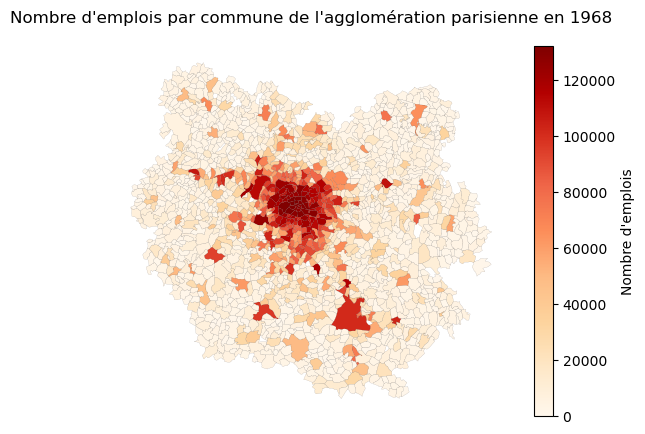

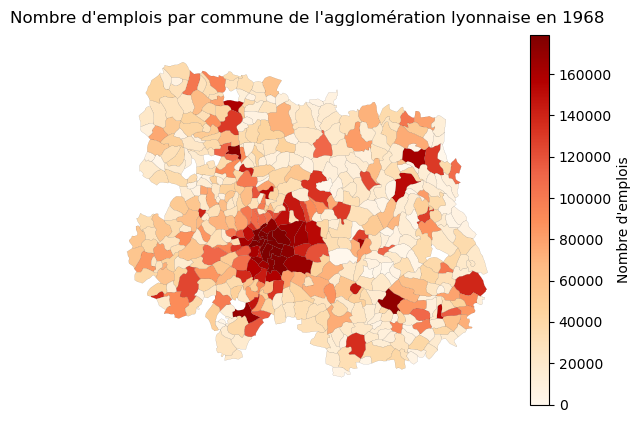

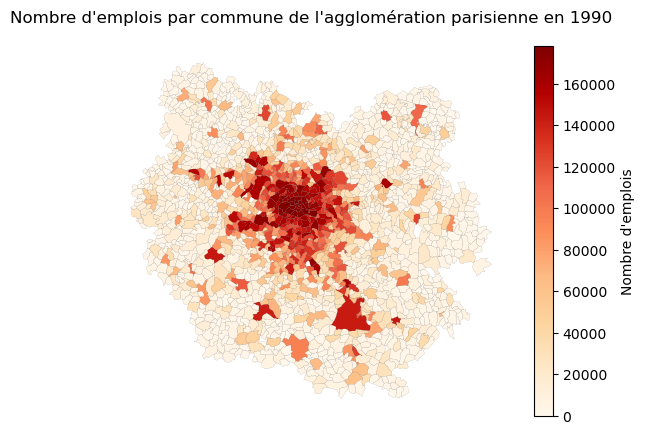

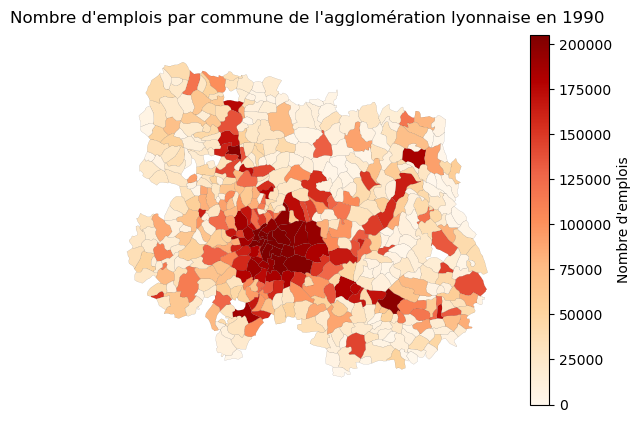

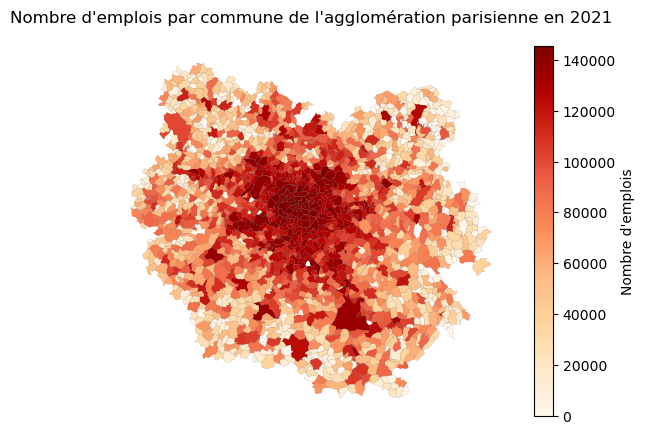

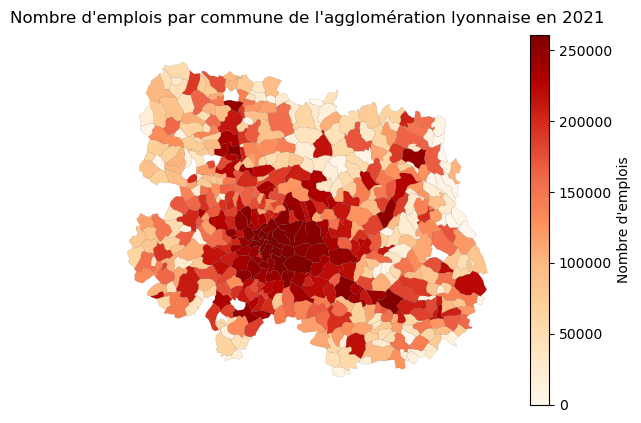

In [7]:
# Ajout pour utilisation de "code" comme variable commune entre les deux datasets
communes_gdf['code'] = communes_gdf['INSEE_COM'].astype(str)
communes_gdf.loc[communes_gdf['code'].isin(map(str, range(69381, 69390))), 'code'] = '69123' #Ajustement des données pour les arrondissements de Lyon

# Fusionner les deux DataFrames sur 'code' (Pour Lyon et Paris)
paris_com_gdf = communes_gdf.merge(p_aglo_df[['code','Total_Emploi_1968', 'Total_Emploi_1990', 'Total_Emploi_2021']], on='code', how='inner')
lyon_com_gdf = communes_gdf.merge(lyon_aglo_df[['code','Total_Emploi_1968', 'Total_Emploi_1990', 'Total_Emploi_2021']], on='code', how='inner')

os.makedirs("../output/img/carte", exist_ok=True)


# Définition de la colormap pour la légende
cmap = plt.cm.OrRd

for annee in années:
    norm = mcolors.Normalize(vmin=paris_com_gdf[f'Total_Emploi_{annee}'].min(), 
                         vmax=paris_com_gdf[f'Total_Emploi_{annee}'].max())

    norm_lyon = mcolors.Normalize(vmin=lyon_com_gdf[f'Total_Emploi_{annee}'].min(), 
                                  vmax=lyon_com_gdf[f'Total_Emploi_{annee}'].max())

    ### PARIS ### 
    # Affichage Carte
    fig, ax = plt.subplots(1, 1)
    paris_com_gdf.plot(column=f'Total_Emploi_{annee}', cmap=cmap, ax=ax, legend=False, edgecolor='black', linewidth=0.05)

    # Création et ajout de la barre de couleur
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Nombre d'emplois")

    plt.title(f"Nombre d'emplois par commune de l'agglomération parisienne en {annee}") 
    plt.axis('off')

    # Enregistrement de la carte
    plt.savefig(f"../output/img/carte/carte_lieu_emplois_Paris_{annee}.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    ### LYON ###
    # Affichage Carte
    fig, ax = plt.subplots(1, 1)
    lyon_com_gdf.plot(column=f'Total_Emploi_{annee}', cmap=cmap, ax=ax, legend=False, edgecolor='black', linewidth=0.05)

    # Création et ajout de la barre de couleur
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_lyon)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Nombre d'emplois")

    plt.title(f"Nombre d'emplois par commune de l'agglomération lyonnaise en {annee}") 
    plt.axis('off')

    # Enregistrement de la carte
    plt.savefig(f"../output/img/carte/carte_lieu_emplois_Lyon_{annee}.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


### Relation: Nombre d'emplois / distance du centre (km)

 #### Création base avec distance

In [13]:
###                         ###
### BASE AVEC DISTANCE PARIS ###
###                         ###

paris_com_gdf[paris_com_gdf["INSEE_COM"] == "75101"]

centre_paris = Point(651283, 6862746) # Coordonnée du 1er Arrondissement

# Fonction pour calculer la distance en km
def calcul_distance(x, y):
    point = Point(x, y)
    return point.distance(centre_paris) / 1000  # Conversion en km

# Calculer la distance pour chaque commune
paris_com_gdf["distance_km"] = paris_com_gdf.apply(lambda row: calcul_distance(row["X_CENTROID"], row["Y_CENTROID"]), axis=1)

dist_paris = paris_com_gdf[["INSEE_COM", "NOM_COM", "distance_km", "Total_Emploi_1968","Total_Emploi_1990","Total_Emploi_2021"]]
dist_paris.head()

###                         ###
### BASE AVEC DISTANCE LYON ###
###                         ###

centre_lyon = Point(842246, 6519522) # Coordonnée du 2ème Arrondissement

# Fonction pour calculer la distance en km
def calcul_distance(x, y):
    point = Point(x, y)
    return point.distance(centre_lyon) / 1000  # Conversion en km

# Calculer la distance pour chaque commune
lyon_com_gdf["distance_km"] = lyon_com_gdf.apply(lambda row: calcul_distance(row["X_CENTROID"], row["Y_CENTROID"]), axis=1)

dist_lyon = lyon_com_gdf[["code", "NOM_COM", "distance_km", "Total_Emploi_1968","Total_Emploi_1990","Total_Emploi_2021"]]
dist_lyon = dist_lyon[ #Filtrage arrondissements pour évier double comptage des données 
    np.where(
        dist_lyon["code"] == '69123',  
        dist_lyon["NOM_COM"] == "LYON-1ER-ARRONDISSEMENT",  
        True  
    )
]  

dist_paris.head( )

,INSEE_COM,NOM_COM,distance_km,Total_Emploi_1968,Total_Emploi_1990,Total_Emploi_2021
0,78269,GAZERAN,47.980558,84,120,556.279867
1,77333,NEMOURS,73.290043,1932,4902,4509.499465
2,77031,BERNAY-VILBERT,48.268052,16,108,52.768445
3,77523,VILLUIS,90.840069,40,12,15.601029
4,77313,MONTMACHOUX,77.047380,28,12,0


#### Etude correlation

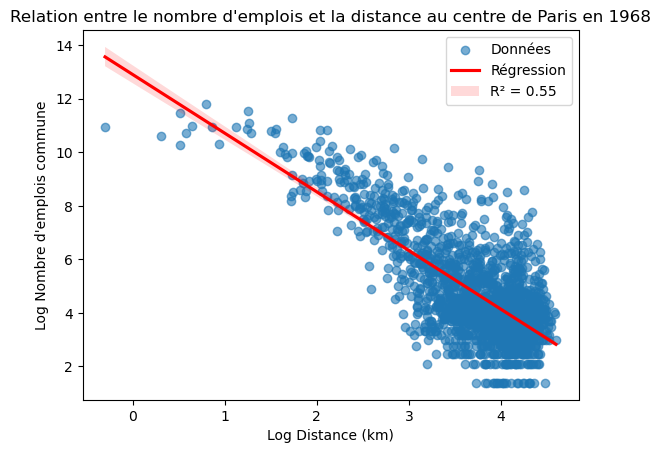

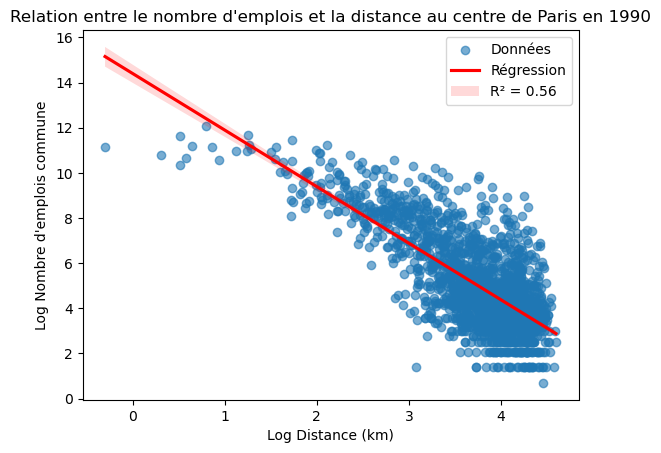

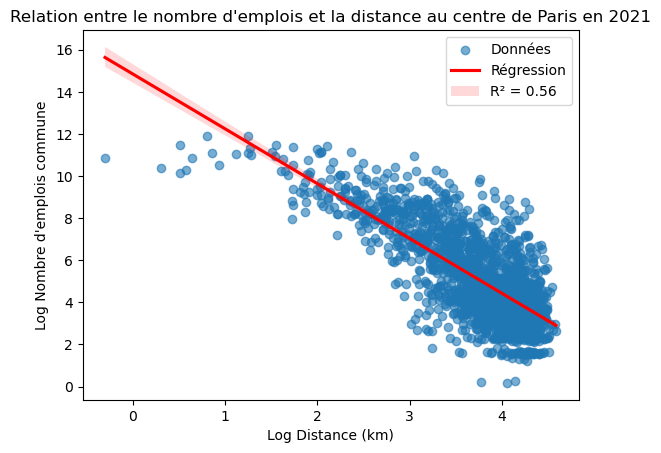

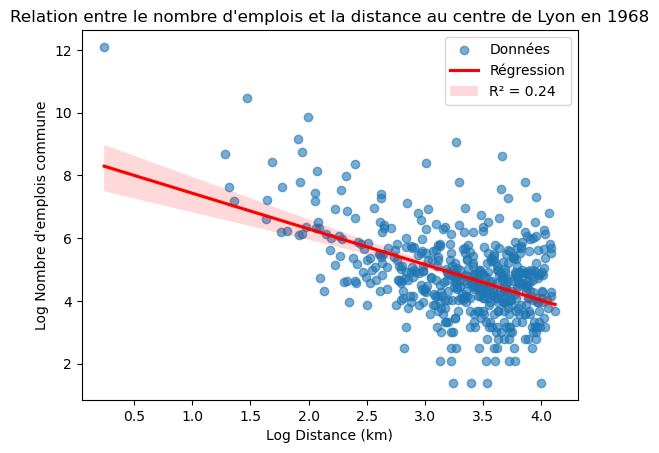

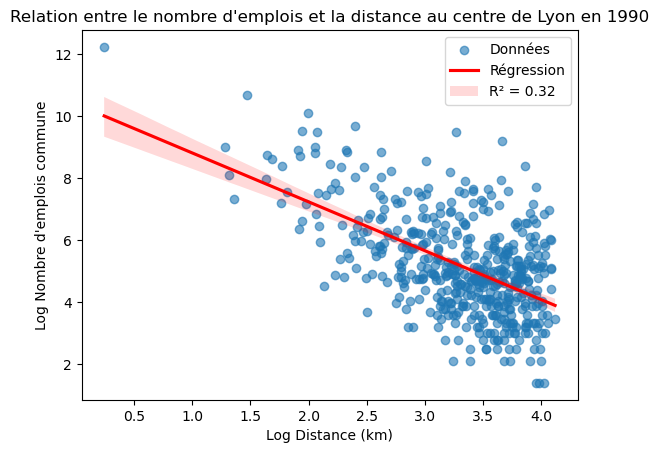

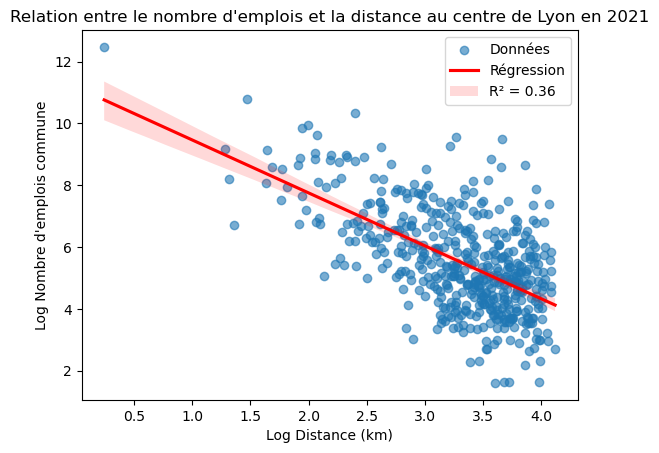

In [9]:
def relation_emp_dist(dist, ville, années):
    dist_cop = dist.copy()

    for annee in années:

        # Conversion en numérique
        dist_cop["distance_km"] = pd.to_numeric(dist_cop["distance_km"], errors="coerce")
        dist_cop[f"Total_Emploi_{annee}"] = pd.to_numeric(dist_cop[f"Total_Emploi_{annee}"], errors="coerce")

        # Remplacement des NaN et des 0
        dist_cop["distance_km"] = dist_cop["distance_km"].replace({0: np.nan})
        dist_cop[f"Total_Emploi_{annee}"] = dist_cop[f"Total_Emploi_{annee}"].replace({0: np.nan})
        dist_cop.dropna(subset=["distance_km", f"Total_Emploi_{annee}"], inplace=True)

        # Calcul des logarithmes
        dist_cop["log_distance_km"] = np.log(dist_cop["distance_km"])
        dist_cop[f"log_Total_Emploi_{annee}"] = np.log(dist_cop[f"Total_Emploi_{annee}"])

        #Calcul du R^2 de la régression pour affichage dans graphique
        results = smf.ols(f"log_Total_Emploi_{annee} ~ log_distance_km", data=dist_cop).fit()
        r_squared = results.rsquared

        # Tracé du graphique
        sns.regplot(x=dist_cop['log_distance_km'], y=dist_cop[f'log_Total_Emploi_{annee}'], 
                    scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
        plt.title(f"Relation entre le nombre d'emplois et la distance au centre de {ville} en {annee}")
        plt.xlabel("Log Distance (km)")
        plt.ylabel("Log Nombre d'emplois commune")
        plt.legend(["Données", "Régression", f"R² = {r_squared:.2f}"], loc='upper right')

        # Sauvegarde du graphique
        os.makedirs("../output/img/relation", exist_ok=True)
        plt.savefig(f"../output/img/relation/rel_nb_emp_dist_{ville}_{annee}.png")

        plt.show()


# Exécution fonction pour Paris et Lyon
relation_emp_dist(dist_paris, "Paris", années)
relation_emp_dist(dist_lyon, "Lyon", années)


#### OLS Résultats

In [10]:
os.makedirs("../output/OLS", exist_ok=True)

def ols_model(dist, ville, années):
    dist_cop = dist.copy()
    for annee in années:

        # Conversion en numérique
        dist_cop["distance_km"] = pd.to_numeric(dist_cop["distance_km"], errors="coerce")
        dist_cop[f"Total_Emploi_{annee}"] = pd.to_numeric(dist_cop[f"Total_Emploi_{annee}"], errors="coerce")

        # Remplacement des NaN et des 0
        dist_cop["distance_km"] = dist_cop["distance_km"].replace({0: np.nan})
        dist_cop[f"Total_Emploi_{annee}"] = dist_cop[f"Total_Emploi_{annee}"].replace({0: np.nan})
        dist_cop.dropna(subset=["distance_km", f"Total_Emploi_{annee}"], inplace=True)

        # Calcul des logarithmes
        dist_cop["log_distance_km"] = np.log(dist_cop["distance_km"])
        dist_cop[f"log_Total_Emploi_{annee}"] = np.log(dist_cop[f"Total_Emploi_{annee}"])

        results = smf.ols(f"log_Total_Emploi_{annee} ~ log_distance_km", data=dist_cop).fit()

        print(f" Résultats pour agglomération {ville} {annee}: ")
        print()
        output_chemin_ols = f"../output/OLS/MCO_dist_emploi_{ville}_{annee}.txt"
        with open(output_chemin_ols, "w") as f:
            f.write(results.summary().as_text())
   
        print(results.summary()) 
        print()

# Exécution de la fonction pour Paris et Lyon
ols_model(dist_paris, "Paris", années)
ols_model(dist_lyon, "Lyon", années)

 Résultats pour agglomération Paris 1968: 

                              OLS Regression Results                             
Dep. Variable:     log_Total_Emploi_1968   R-squared:                       0.549
Model:                               OLS   Adj. R-squared:                  0.549
Method:                    Least Squares   F-statistic:                     2138.
Date:                   Wed, 26 Mar 2025   Prob (F-statistic):          6.59e-306
Time:                           23:16:04   Log-Likelihood:                -2905.6
No. Observations:                   1757   AIC:                             5815.
Df Residuals:                       1755   BIC:                             5826.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

 #### Etude répartition cumulative des emplois

Pour Paris en 1968, la part cumulée des emplois avant 10 km est de 67.42%


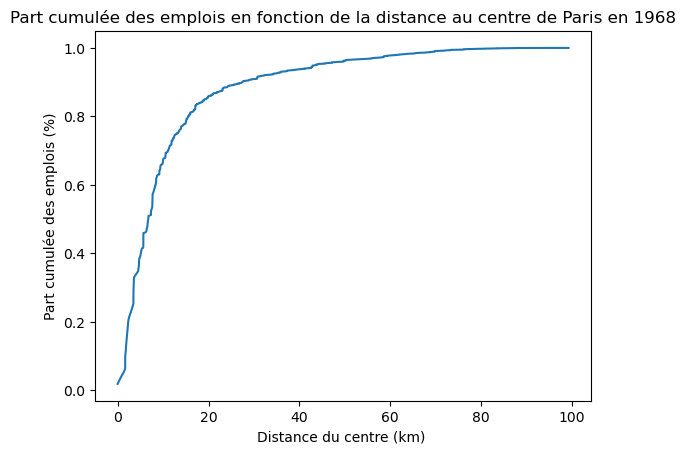

Pour Paris en 1990, la part cumulée des emplois avant 10 km est de 56.53%


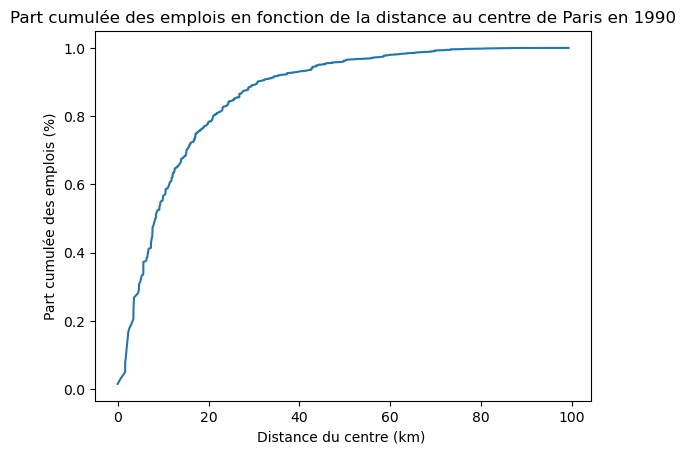

Pour Paris en 2021, la part cumulée des emplois avant 10 km est de 54.79%


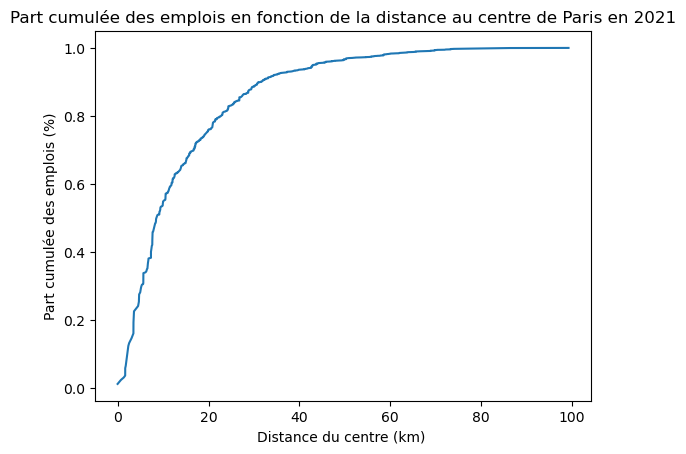

Pour Lyon en 1968, la part cumulée des emplois avant 10 km est de 72.27%


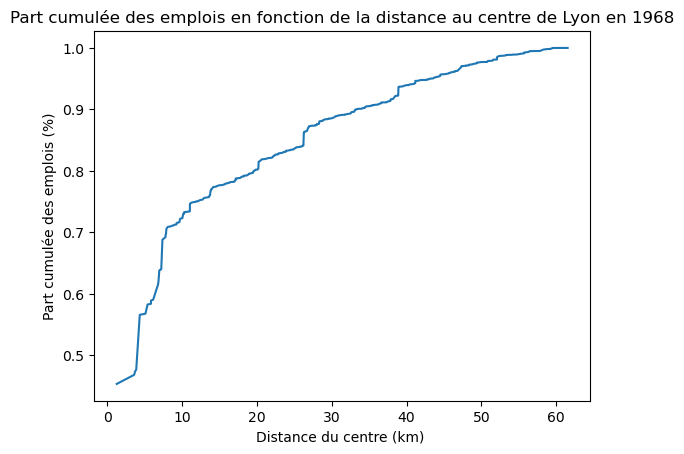

Pour Lyon en 1990, la part cumulée des emplois avant 10 km est de 63.32%


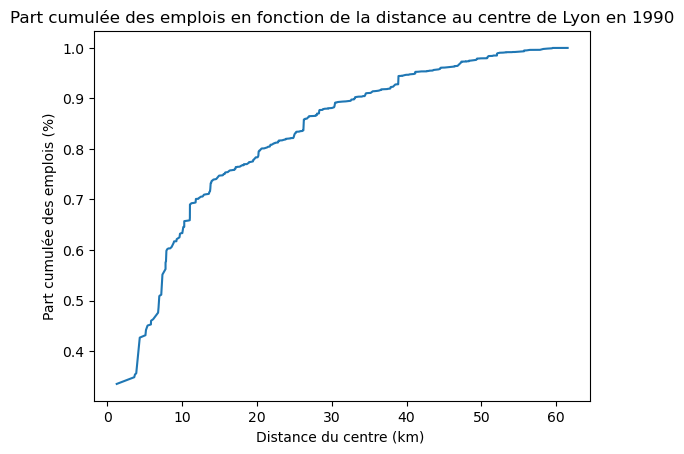

Pour Lyon en 2021, la part cumulée des emplois avant 10 km est de 58.48%


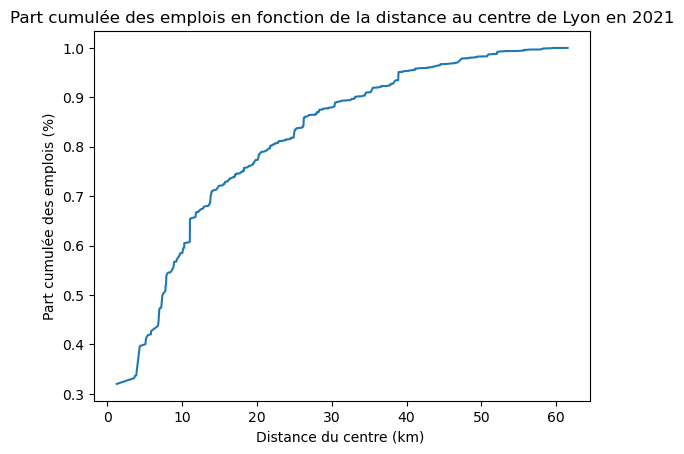

In [11]:
# Création du dossier de sortie
os.makedirs("../output/img/relation", exist_ok=True)


def repartition_cumulative(dist, ville, annees):
    dist_cop = dist.copy()
    for annee in années:
        # Trier par distance
        dist_cop = dist_cop.sort_values(by="distance_km").reset_index(drop=True)
        # Calculer la part cumulée des emplois
        dist_cop["Part_cumulee"] = dist_cop[f"Total_Emploi_{annee}"].cumsum() / dist_cop[f"Total_Emploi_{annee}"].sum()

        # Afficher la part cumulée dans les 10 premiers kilomètres
        part_avant_10km = dist_cop.loc[dist_cop["distance_km"] < 10, "Part_cumulee"].max()
        print(f"Pour {ville} en {annee}, la part cumulée des emplois avant 10 km est de {part_avant_10km:.2%}")
        

        # Tracer le graphique
        plt.plot(dist_cop["distance_km"], dist_cop["Part_cumulee"])
        plt.title(f"Part cumulée des emplois en fonction de la distance au centre de {ville} en {annee}")
        plt.xlabel("Distance du centre (km) ")
        plt.ylabel("Part cumulée des emplois (%)")

        # Enregistrement du graphique
        output = f"../output/img/relation/cumule_emp_dist_{ville}_{annee}.png"
        plt.savefig(output, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.show()
        
repartition_cumulative(dist_paris, "Paris", années)
repartition_cumulative(dist_lyon, "Lyon", années)
    
    